# Importing Relevant Libraries 

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms 
import torchvision.datasets as Datasets
from torchvision.utils import save_image

from PIL import Image

import os

import numpy as np
import matplotlib.pyplot as plt

# Defining dataset paths 

In [2]:
train_dataset_path = './imgs/training'
validation_dataset_path = './imgs/validation'
test_dataset_path = './imgs/test'

# Defining Transforms

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

In [114]:
#########################################################################################################################
#Personal note on transforms.Compose:

#   This composes all of the transforms to be applied together
#   First we resi`e all the images to a guven size. This is because CNN requires all input images to be of the
#   same size to
#   work properly
#   We alse tranform all the images to tensors. In pytorchs .ToTensors(), it changes the images to (N, C, H, W),
#   where  is the
#   the batch size, C is channel, H is height and W is width

#########################################################################################################################

# Defining datasets

In [4]:
train_dataset = Datasets.ImageFolder(root = train_dataset_path, transform = transform)
validation_dataset = Datasets.ImageFolder(root = validation_dataset_path, transform = transform) 
test_dataset = Datasets.ImageFolder(root = test_dataset_path, transform = transform) 

In [116]:
#########################################################################################################################
#Personal Note on Datsets.ImageFolder:

#   root (string) – Root directory path.
#   transform (callable, optional) – A function/transform that takes in an image and returns a transformed
#   version

#   We can use these datasets to create our iterable data loaders.

#########################################################################################################################

# Making Dataloaders

In [5]:
training_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 12, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 12, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 4, shuffle=True)

In [118]:
#########################################################################################################################
#Personal Note on orch.utils.data.DataLoader:

#   Below, under the Training functions heading you can see we use map-style dataloader
#   such a dataset, when accessed with dataset[idx], could read the idx-th image and its corresponding label
#   from a folder 
#   on the disk.
#   DataLoader supports automatically collating individual fetched data samples into batches via arguments
#   batch_size
#   



# Configuring Device

In [6]:

# # this ensures that the current MacOS version is at least 12.3+
# print(torch.backends.mps.is_available())
# # this ensures that the current current PyTorch installation was built with MPS activated.
# print(torch.backends.mps.is_built())

device = torch.device('cpu')
print('Running on the CPU')

Running on the CPU


# Defining Encoder 

In [8]:

class encoder(nn.Module):
  def __init__(self, out_channels=16, latent_dim=256):
    super().__init__()

    self.net = nn.Sequential(
        nn.Conv2d(3, 16, 3, padding=1), 
        nn.ReLU(),
        nn.Conv2d(16, 16, 3, padding=1), 
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, padding=1,stride = 2),
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, stride = 2, kernel_size = 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, padding=1), 
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, padding=1, stride =2), 
        nn.ReLU(),
        nn.Dropout(0.05),
        nn.Conv2d(128, 128, 3, padding=1), 
        nn.ReLU(),
        nn.Dropout(0.05),
        nn.Flatten(),
        nn.Linear(32*out_channels*8*8, latent_dim),
        nn.ReLU(),
    )

  def forward(self, x):
    x = x.view(-1, 3, 128, 128)
    output = self.net(x)
    return output


In [9]:
#########################################################################################################################
# Personal Note on encoder:

#The dropout layer has been added to prevent over fitting. There are two dropout layers at the end of the
#encoder and the two add the start of the decoder all at a dropout rate of 0.05

#The dropoiut layer randomly disactivates some neurons, in this case random 5% of neurons.

#the 32x32 image is porcessed until it is an 8x8 feature map and then is flattened to a vector of 4096.
# A linear layer is applied to comporess it to a previously defined latent dimension of 228. This latent
# dimension is the size of the bottleneck

# The linear layer is also know as the fully connected layer
# this layer helps in changing dimesionality of the output from the preceding layer. The input features
# are received by a linear layer are passed in the form of a flattned oe dimension tensor and the multiplied
# by a weight matrix

# Defining Decoder

In [10]:
class decoder(nn.Module):
  def __init__(self, in_channels=3, out_channels=16, latent_dim=256):
    super().__init__()

    self.out_channels = out_channels

    self.linear = nn.Sequential(
        nn.Linear(latent_dim, 32*out_channels*8*8),
        nn.ReLU(),
    )

    self.conv = nn.Sequential(
        nn.ConvTranspose2d(8*out_channels, 8*out_channels, 3, padding=1), # (8, 8)
        nn.ReLU(),
        nn.Dropout(0.05),
        nn.ConvTranspose2d(8*out_channels, 4*out_channels, 3, padding=1, 
                           stride=2, output_padding=1), 
        nn.ReLU(),
        nn.Dropout(0.05),
        nn.ConvTranspose2d(4*out_channels, 4*out_channels, 3, padding=1), 
        nn.ReLU(),
        nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, padding=1, 
                           stride=2, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(2*out_channels, 2*out_channels, 3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(2*out_channels, out_channels, 3, padding=1, 
                           stride=2, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1)
    )

  def forward(self, x):
    output = self.linear(x)
    output = output.view(-1, 128, 16, 16)
    output = self.conv(output)
    return output



In [11]:
#########################################################################################################################
# Personal Note on decoder:

#The first thing that needs to be done is to add the linear layer. So under the "def forward(self, x)",
# we apply the linear layer and then the conv layers

#.view(): 
#   It reshapes the tenosr without copying memory
#   The "-1", is when there is any situation where you dont know how many rows you want but are sure of
#   the number of 
#   columns. Asking " Give me a tensor that has these many columns and you compute the appropriate number
#   of rows to make this happen "
#########################################################################################################################

# Defining Autoencoder

In [12]:
#  defining autoencoder
class autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.encoder.to(device)
    
    self.decoder = decoder
    self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Summarizing Autoencoder

In [13]:
enc = encoder().to(device)
# summary(enc, input_size=(1, 3, 128, 128))
dec = decoder().to(device)
# summary(dec, input_size=(1, 256))


# Training model function

In [14]:
#defining model 
model = autoencoder(encoder(), decoder())

def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 128, 128)
    save_image(img, name)
    
LEARNING_RATE = 1e-3

criterion = nn.MSELoss() #Mean error loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 

def train(net, trainloader, validationloader, NUM_EPOCHS):

    train_loss = [] #record the train loss after each epoch
    val_loss = [] #record the validation loss after each epoch
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        running_loss_val = 0.0

        ################ TRAINING ################
        #iterating through the training loader
        for data in trainloader: 
            img, _ = data # no need for the labels
            img = img.to(device)
            optimizer.zero_grad() # setting gradients of all the optimize tensors to zer
            outputs = net(img) # putting image through the cnn
            loss = criterion(outputs, img) #calculating loss using mean squared error
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        ############### VALIDATION ###############

        for val_data in validationloader:
            img_val, _ = val_data
            img_val = img_val.to(device)
            output_val = net(img_val)
            loss_val = criterion(output_val, img_val)
            running_loss_val += loss_val.item()

        loss = running_loss / len(trainloader)
        loss_val = running_loss_val/ len(validation_loader)

        val_loss.append(loss_val)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}, Validation Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss, loss_val))
        if epoch % 5 == 0:
            save_decoded_image(img.cpu().data, name='./Images_train/original{}.png'.format(epoch))
            save_decoded_image(outputs.cpu().data, name='./Images_train/decoded{}.png'.format(epoch))
            save_decoded_image(img_val.cpu().data, name='./Images_validation/original_validation{}.png'.format(epoch))
            save_decoded_image(output_val.cpu().data, name='./Images_validation/decoded_validation{}.png'.format(epoch))
    return train_loss, val_loss


def test_image_reconstruction(net, testloader, encoder):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        img_code = encoder(img)
        # print('CODE:')
        # print(img_code)
        # print('EXIT CODE')
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 3, 128, 128).cpu().data
        save_image(img, 'original_images.png')
        save_image(outputs, 'reconstructed_images.png')
        break
     return img_code

In [127]:
#########################################################################################################################
#Personal Notes:

#Adam optimizer: The adam optimizer is sed under the gradient decent algorithm

In [15]:

#Making directory to store the Images
def make_dir():
    train_image_dir = 'Images_train'
    val_image_dir = 'Images_validation'
    if not os.path.exists(train_image_dir):
        os.makedirs(train_image_dir)
    if not os.path.exists(val_image_dir):
        os.makedirs(val_image_dir)
model.train()
model.to(device)
make_dir()
train_loss, val_loss = train(model, training_loader, validation_loader, 20)


/Users/lamiayous/Projects/FindMe/object_detector/.venv/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 of 20, Train Loss: 0.065, Validation Loss: 0.046
Epoch 2 of 20, Train Loss: 0.037, Validation Loss: 0.030
Epoch 3 of 20, Train Loss: 0.031, Validation Loss: 0.027
Epoch 4 of 20, Train Loss: 0.029, Validation Loss: 0.025
Epoch 5 of 20, Train Loss: 0.027, Validation Loss: 0.026
Epoch 6 of 20, Train Loss: 0.026, Validation Loss: 0.023
Epoch 7 of 20, Train Loss: 0.022, Validation Loss: 0.020
Epoch 8 of 20, Train Loss: 0.020, Validation Loss: 0.019
Epoch 9 of 20, Train Loss: 0.019, Validation Loss: 0.018
Epoch 10 of 20, Train Loss: 0.018, Validation Loss: 0.017
Epoch 11 of 20, Train Loss: 0.018, Validation Loss: 0.017
Epoch 12 of 20, Train Loss: 0.018, Validation Loss: 0.017
Epoch 13 of 20, Train Loss: 0.017, Validation Loss: 0.017
Epoch 14 of 20, Train Loss: 0.017, Validation Loss: 0.017
Epoch 15 of 20, Train Loss: 0.016, Validation Loss: 0.016
Epoch 16 of 20, Train Loss: 0.016, Validation Loss: 0.016
Epoch 17 of 20, Train Loss: 0.016, Validation Loss: 0.016
Epoch 18 of 20, Train L

In [16]:
import copy
copy = copy.deepcopy(model)

# Unique code function

In [17]:
def unique_code_files(img_codes):
    codes_arr = torch.detach(img_codes).numpy()
    no_imgs = len(codes_arr)
    index = 0 

    while index < no_imgs:
        img_no = str(index)
        filename = ("UniqueCode" + img_no + ".txt")
        np.savetxt(filename, codes_arr[index])
        index += 1


In [18]:
FILE = "last.pth"
torch.save(copy.state_dict(), FILE)

# Test Result

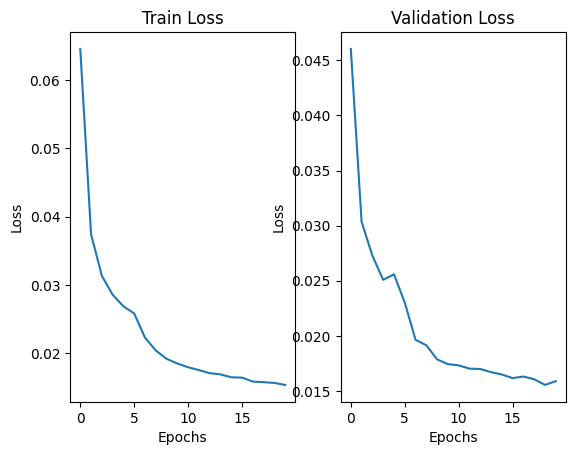

In [27]:
copy.load_state_dict(torch.load(FILE))
copy.eval()

img_codes = test_image_reconstruction(model, test_loader, encoder())
unique_code_files(img_codes)
# img = torch.detach(img_code).numpy()
# np.savetxt('CODE.txt', torch.detach(img_code).numpy())
#plotting training and validation results 

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('training_loss.png')

plt.subplot(1, 2, 2)
plt.plot(val_loss)
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('validation_loss.png')